# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

## Dataset

### Loading

In [1]:
from scripts.data.load import load_dataset

dataset_name = "scapes"

dataset = load_dataset(dataset_name, normalize=True, batch=True, colab=True)

Found 12000 files belonging to 1 classes.


### Training image preview

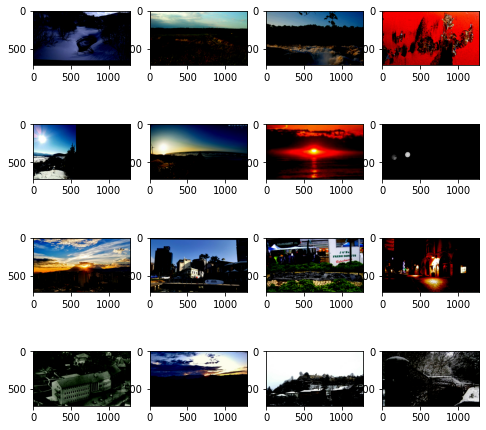

In [3]:
from scripts.data.visualization import display_images
import tensorflow as tf

# Take doesn't alter the dataset itself, so this won't affect the training
for batch in dataset.take(1):
    display_images(batch.numpy(), max_images=32)


## Load Config

In [2]:
from config import get_config

config = get_config(dataset_name)

## Build GAN

In [3]:
from scripts.model.build import build_model
model_name = "dcgan"
generator, discriminator = build_model(model_name, dataset_name)

## Model summaries

In [2]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 921600)            93081600  
                                                                 
 reshape (Reshape)           (None, 90, 160, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 180, 320, 32)     18464     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 180, 320, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 360, 640, 32)     9248      
 ranspose)                                                       
                                                        

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12545     
                                                                 
Total params: 308,993
Trainable params: 308,993
Non-tr

## Test Generator output

0.000104032726 0.005349449 -0.0050187306


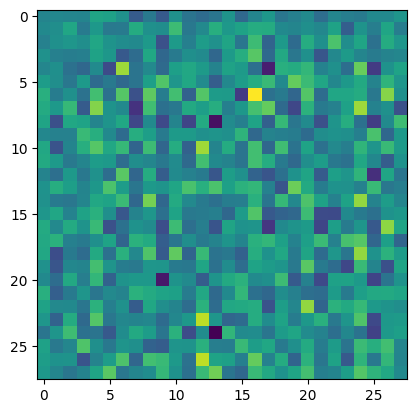

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

input_noise = tf.random.normal([1, 100])
generated_image = generator(input_noise, training=False)[0]
print(np.average(generated_image), np.max(generated_image), np.min(generated_image))
# generated_image[0]
plt.imshow(generated_image)

## Test Discriminator output

In [9]:
decision = discriminator(np.reshape(
                                        generated_image,                    
                                        (1, 
                                        config['dataset']['height'], 
                                        config['dataset']['width'], 
                                        config['dataset']['num_color_channels'])
                                    )
                        )
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49999186]], dtype=float32)>

## Get optimizers

In [4]:
generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

In [27]:
import  time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from scripts.model.loss import generator_loss, discriminator_loss

def generate_and_save_images(model, epoch, test_seeds):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

@tf.function
def train_step(real_image_batch):
    input_noise_seeds = tf.random.normal([config['dataset']['batch_size'], config['len_seed']])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image_batch = generator(input_noise_seeds, training=True)

        y_pred_real = discriminator(real_image_batch, training=True)
        y_pred_fake = discriminator(generated_image_batch, training=True)

        gen_loss = generator_loss(y_pred_fake)
        disc_loss = discriminator_loss(y_pred_real, y_pred_fake)

    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

    # return gen_loss, disc_loss

def train(dataset, epochs, num_test_seeds=16):

    if num_test_seeds < 1:
        print('Number of test seeds invalid (must be > 0)')
        return
  
    test_seeds = tf.random.normal([num_test_seeds, config['len_seed']])

    for epoch in range(epochs):
        start = time.time()
        # gen_loss, disc_loss = None, None

        for i, batch in enumerate(dataset):
            display.clear_output(wait=True)
            # print(f'Loss for previous batch #{i}: Generator loss = {gen_loss}, Discriminator loss = {disc_loss}')
            print(f'Epoch # {epoch + 1}/{epochs}')
            print(f'Batch # {i + 1}')
            train_step(batch)
        
        generate_and_save_images(generator, epoch + 1, test_seeds)


        print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')
  
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, test_seeds)

In [13]:
input_noise_seeds = tf.random.normal([config['dataset']['batch_size'], config['len_seed']])
input_noise_seeds

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.07833955, -0.43065158,  0.9406565 , ...,  1.1693199 ,
         0.07661634, -0.6088764 ],
       [ 0.2158999 ,  1.6334144 , -0.12918077, ...,  0.84702945,
        -1.2724671 ,  0.4265181 ],
       [-0.46373567,  0.23446678,  1.1945037 , ...,  0.9081218 ,
        -0.8753421 ,  0.63028985],
       ...,
       [ 0.6295884 ,  0.2948492 ,  0.37177396, ..., -1.0958065 ,
        -0.55484045, -0.8853298 ],
       [ 0.3997303 ,  0.83574075, -1.5901245 , ...,  0.5359854 ,
         0.07721165, -0.7394747 ],
       [ 0.36600295,  0.59261775, -0.16767694, ..., -0.72462523,
        -2.0916045 ,  0.22309184]], dtype=float32)>

## Training the model

In [28]:
import time
from scripts.model.hyperparameters import get_dcgan_hyperparameters

generator_optimizer = config['dataset'][model_name]['generator']['optimizer']
discriminator_optimizer = config['dataset'][model_name]['discriminator']['optimizer']

models = {
    'generator': {
        'model': generator,
        'loss': generator_loss,
        'optimizer': discriminator_optimizer
    },
    'discriminator': {
        'model': discriminator,
        'loss': discriminator_loss,
        'optimizer': discriminator_optimizer
    }
}

start = time.time()
train(dataset, epochs=1)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

Epoch # 1/1
Batch # 43


KeyboardInterrupt: 

## Rescaling image output from [-1, 1] to [0, 255]

In [ ]:
rand_seed = tf.random.normal([1, 100])
image = generator(rand_seed, training=False)[0]
image = image.numpy()
image = ((image - np.min(image)) * 255) / (np.max(image) - np.min(image))
# image
# image = ((image * 127.5) + 127.5)
image = image.astype(np.uint8)
plt.imshow(image)

In [ ]:
image = (image + 1)/(2) * 255
np.min(image), np.max(image)
# # image = np.expand_dims(image, axis=0)
# # rand_seed
plt.imshow(image[:, :, 0], cmap='gray')

## Saving the model

In [ ]:
generator.save('./models/generator')

In [ ]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator